In [1]:
#Ref - https://towardsdatascience.com/random-forest-in-python-24d0893d51c0
import pandas as pd
import numpy as np
import datetime
import talib as ta
import matplotlib.pyplot as plt
import seaborn as sns
import talib as ta

In [2]:
#Read data
data = pd.read_csv('data/analysis/D1_XAUUSD_Returns.csv', parse_dates=[0], index_col='Date')
#print(data.head())

In [3]:
#Date related features
data['Week'] = data.index.week
data['Day_Week'] = data.index.dayofweek
data['daily_return'] = data.Close.pct_change().mul(100)
data['day_week_sin'] = np.sin(data.Day_Week*(2.*np.pi/7))
data['day_week_cos'] = np.cos(data.Day_Week*(2.*np.pi/7))
data['week_sin'] = np.sin((data.Week-1)*(2.*np.pi/52))
data['week_cos'] = np.cos((data.Week-1)*(2.*np.pi/52))
data['yearday_sin'] = np.sin((data.Yearday)*(2.*np.pi/365.25))
data['yearday_cos'] = np.cos((data.Yearday)*(2.*np.pi/365.25))
#Simple Moving Average - 50 day
data['SMA_50'] = ta.SMA(data.Close, timeperiod = 50)
#Simple Moving Average - 200 day
data['SMA_200'] = ta.SMA(data.Close, timeperiod = 200)
# Exponential Moving Average - 9 day
data['EMA_9'] = ta.EMA(data.Close, timeperiod = 9)
# Exponential Moving Average - 21 day
data['EMA_21'] = ta.EMA(data.Close, timeperiod = 21)
# MACD
data['macd'], data['macdsignal'], data['macdhist'] = ta.MACD(data.Close, fastperiod=12, slowperiod=200, signalperiod=9)
# RSI
data['RSI'] = ta.RSI(data.Close, timeperiod=14)
#Define relative indicators
data['SMA_Delta'] = (data['SMA_50'] - data['SMA_200']) / data['Close']
#Define relative indicators
data['EMA_Delta'] = (data['EMA_9'] - data['EMA_21']) / data['Close']

In [4]:
print(data.tail())

               Open     High      Low    Close  Volume    Weekday  Yearday  \
Date                                                                         
2019-04-03  1291.70  1294.49  1288.34  1291.76   94534  Wednesday       93   
2019-04-04  1291.76  1294.34  1280.85  1292.10   77631   Thursday       94   
2019-04-05  1292.10  1293.15  1284.33  1291.18  102223     Friday       95   
2019-04-07  1291.31  1293.63  1291.20  1291.67    2133     Sunday       97   
2019-04-08  1291.73  1303.65  1291.58  1297.94   73029     Monday       98   

            Return_per_day  Return_log  Week  ...     SMA_50     SMA_200  \
Date                                          ...                          
2019-04-03        0.004645    0.000046    14  ...  1308.0620  1252.10065   
2019-04-04        0.026321    0.000263    14  ...  1307.6060  1252.59180   
2019-04-05       -0.071202   -0.000712    14  ...  1307.2982  1253.17900   
2019-04-07        0.027879    0.000379    14  ...  1306.9242  1253.76085 

In [5]:
#Choosing target variable
#data['Large_return'] = np.where(data['daily_return']>=0.5, 1, (np.where(data['daily_return']<=-0.5, -1, 0)))

In [6]:
#Drop rows with nan values
data.dropna(inplace=True)

In [7]:
#Pick features
features_list = ['Volume','day_week_sin','day_week_cos','week_sin','week_cos','yearday_sin','yearday_cos',
                 'macdhist', 'RSI', 'SMA_Delta','EMA_Delta']
features = data[features_list]
features.head()

,Volume,day_week_sin,day_week_cos,week_sin,week_cos,yearday_sin,yearday_cos,macdhist,RSI,SMA_Delta,EMA_Delta
Date,,,,,,,,,,,
2004-01-12,20736,0.000000,1.000000,0.239316,0.970942,0.204966,0.978769,2.239954,70.847411,0.071611,0.011534
2004-01-13,21473,0.781831,0.623490,0.239316,0.970942,0.221772,0.975099,1.835514,68.227339,0.072198,0.010996
2004-01-14,20415,0.974928,-0.222521,0.239316,0.970942,0.238513,0.971139,0.945729,57.107955,0.073547,0.009352
2004-01-15,22449,0.433884,-0.900969,0.239316,0.970942,0.255182,0.966893,-0.982156,39.857679,0.075568,0.005214
2004-01-16,19571,-0.433884,-0.900969,0.239316,0.970942,0.271777,0.962360,-2.539018,37.444023,0.076086,0.001362


In [8]:
#Pick target variable 
target_unshifted = data['daily_return']
#Add shift so we can predict target on time t=1 with features from time t
target = target_unshifted.shift(-1)
#Drop last value from features and target (Nan)
features = features[:-1]
target = target[:-1]
print(features.tail())
print(target.tail())

            Volume  day_week_sin  day_week_cos  week_sin      week_cos  \
Date                                                                     
2019-04-02   84862      0.781831      0.623490       1.0  6.123234e-17   
2019-04-03   94534      0.974928     -0.222521       1.0  6.123234e-17   
2019-04-04   77631      0.433884     -0.900969       1.0  6.123234e-17   
2019-04-05  102223     -0.433884     -0.900969       1.0  6.123234e-17   
2019-04-07    2133     -0.781831      0.623490       1.0  6.123234e-17   

            yearday_sin  yearday_cos  macdhist        RSI  SMA_Delta  \
Date                                                                   
2019-04-02     0.999930    -0.011826 -5.395313  42.392384   0.044015   
2019-04-03     0.999579    -0.029025 -5.344675  42.440840   0.043322   
2019-04-04     0.998932    -0.046215 -5.125334  42.734791   0.042577   
2019-04-05     0.997989    -0.063391 -4.943795  42.108149   0.041915   
2019-04-07     0.995218    -0.097683 -4.629876  4

In [9]:
def split_train_test(data, train_ratio):
    indices = np.arange(len(data))
    train_set_size = int(len(data) * train_ratio)
    train_indices = indices[:train_set_size]
    test_indices = indices[train_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

X_train_set, X_test_set = split_train_test(features, 0.8)

In [10]:
print(len(X_train_set))
print(len(X_test_set))
print("Training Series:", "\n", X_train_set.head(), "\n")
print("Training Series:", "\n", X_train_set.tail(), "\n")
print("Testing Series:", "\n", X_test_set.head())
print("Testing Series:", "\n", X_test_set.tail())

3802
951
Training Series: 
             Volume  day_week_sin  day_week_cos  week_sin  week_cos  \
Date                                                                 
2004-01-12   20736      0.000000      1.000000  0.239316  0.970942   
2004-01-13   21473      0.781831      0.623490  0.239316  0.970942   
2004-01-14   20415      0.974928     -0.222521  0.239316  0.970942   
2004-01-15   22449      0.433884     -0.900969  0.239316  0.970942   
2004-01-16   19571     -0.433884     -0.900969  0.239316  0.970942   

            yearday_sin  yearday_cos  macdhist        RSI  SMA_Delta  \
Date                                                                   
2004-01-12     0.204966     0.978769  2.239954  70.847411   0.071611   
2004-01-13     0.221772     0.975099  1.835514  68.227339   0.072198   
2004-01-14     0.238513     0.971139  0.945729  57.107955   0.073547   
2004-01-15     0.255182     0.966893 -0.982156  39.857679   0.075568   
2004-01-16     0.271777     0.962360 -2.539018  3

In [11]:
y_train_set, y_test_set = split_train_test(target, 0.8)

In [12]:
print(len(y_train_set))
print(len(y_test_set))
print("Training Series:", "\n", y_train_set.head(), "\n")
print("Training Series:", "\n", y_train_set.tail(), "\n")
print("Testing Series:", "\n", y_test_set.head())
print("Testing Series:", "\n", y_test_set.tail())

3802
951
Training Series: 
 Date
2004-01-12   -0.211964
2004-01-13   -1.038471
2004-01-14   -2.587646
2004-01-15   -0.526380
2004-01-16   -0.135368
Name: daily_return, dtype: float64 

Training Series: 
 Date
2016-03-10   -1.625428
2016-03-11    0.191140
2016-03-13   -1.329044
2016-03-14   -0.266153
2016-03-15    2.102463
Name: daily_return, dtype: float64 

Testing Series: 
 Date
2016-03-16    0.017478
2016-03-17   -0.332809
2016-03-18   -0.133090
2016-03-20   -0.760502
2016-03-21    0.382763
Name: daily_return, dtype: float64
Testing Series: 
 Date
2019-04-02    0.004645
2019-04-03    0.026321
2019-04-04   -0.071202
2019-04-05    0.037950
2019-04-07    0.485418
Name: daily_return, dtype: float64


In [28]:
# Fit regression model
#Ref - https://acadgild.com/blog/gradient-boosting-for-regression-problems
from sklearn import ensemble
from sklearn.metrics import mean_squared_error

params = {'n_estimators': 100, 'max_depth': 20, 'min_samples_split': 20, 'min_samples_leaf': 10, 
          'learning_rate': 0.1, 'loss': 'ls'}
model = ensemble.GradientBoostingRegressor(**params)
model.fit(X_train_set, y_train_set.values.ravel())


GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=20, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=10,
             min_samples_split=20, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [29]:
from sklearn.metrics import mean_squared_error, r2_score
model_score = model.score(X_train_set,y_train_set)
# Have a look at R sq to give an idea of the fit ,
# Explained variance score: 1 is perfect prediction
print('R2 sq: ',model_score)
y_model = model.predict(X_test_set)

# The mean squared error
print("Mean squared error: %.2f"% mean_squared_error(y_test_set, y_model))
# Explained variance score: 1 is perfect prediction
print('Test Variance score: %.2f' % r2_score(y_test_set, y_model))

R2 sq:  0.8579462022935402
Mean squared error: 0.71
Test Variance score: -0.77


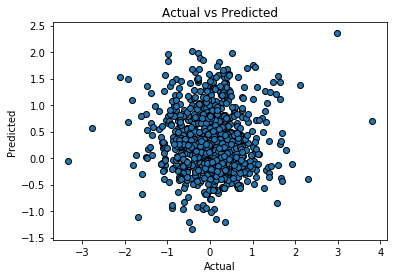

In [23]:
# So let's run the model against the test data
from sklearn.model_selection import cross_val_predict

fig, ax = plt.subplots()
ax.scatter(y_test_set, y_model, edgecolors=(0, 0, 0))
ax.set_xlabel('Actual')
ax.set_ylabel('Predicted')
ax.set_title("Actual vs Predicted")
plt.show()